## Compute Atmospheric Relative Angular Momentum from CFSR Data
###### Inputs: 0.5 deg lat/lon grib2 data obtained from CFS Reanalysis (CFSR); need u-wind at all pressure levels 1000-1 hPa			
###### Outputs: Global Relative Atmospheric Angular Momentum  with units:
$$kg \cdot m^2 \cdot s^{-1}$$
##### Created by: Dr. Victor Gensini (Fall 2016) | weather.cod.edu/~vgensini								

In [1]:
#Import neccessary Python libraries (this example uses Python 2.7)
import numpy as np
import math, pygrib
import matplotlib.pyplot as plt

In [2]:
#Declare physical constants
pi = math.pi #Pi
rad = pi/180. #radians
gravity = 9.81 #gravitational acceleration ms^-2
earth_r = 6371220. #Earth's radius in (m)

### Pick a datetime for calculation (valid 1979-2010)

In [3]:
year = 2004 #1979-2010
month = 4 #1-12
day = 20 #1-28/29/30/31
hour = 18 #0,6,12,18

### Open a CFSR grib2 file
##### Data for this example obtained from: http://rda.ucar.edu/datasets/ds093.0/
##### 6-hourly pressure level data also available from: http://nomads.ncdc.noaa.gov/modeldata/cmd_pgbh/

In [4]:
#I've concatenated CFSR 6-hrly data into monthly chunks following a format of <cfsr_YYYYMM.grb2>
data_file = '/home/vgensini/data/CFSR/cfsr_'+str(year)+str('%02d'%month)+'.grb2'

In [5]:
gr = pygrib.open(data_file) #Read CFSR grib2 file containing u-winds at all pressure levels into memory

### Read in all U-component (i.e., zonal) wind values

In [6]:
umsgs = gr.select(name='U component of wind',typeOfLevel='isobaricInhPa', year=year,month=month,day=day, hour=hour)

In [7]:
lats,lons = umsgs[0].latlons() #Read the lat/lon information from the u-wind grib2 message

In [8]:
uwnd = np.zeros((361, 720, 37)) #Could do some fancy dynamic shape finding here
for i,levs in enumerate(umsgs): #CFSR 0.5 data is x-720,y-361,z-37
    uwnd[:,:,i] = levs.values   #Read zonal wind into a 3-D NumPy array

In [9]:
#dp is difference between CFSR pressure levels in Pa; set lowest and highest dp to zero as they are at integral bounds
#Vertical level information can be found here: http://rda.ucar.edu/datasets/ds093.0/#metadata/detailed.html?_do=y
dps=[0.,100.,200.,200.,300.,1000.,1000.,2000.,2000.,3000.,2500.,2500.,2500.,2500.,2500.,2500.,5000.,5000.,5000.,5000.,5000.,5000.,5000.,5000.,5000.,5000.,2500.,2500.,2500.,2500.,2500.,2500.,2500.,2500.,2500.,2500.,0.]
dps = np.tile(np.array(dps),(361,720,1)) #Create a 3-D NumPy array of dp values

### Calculations
$$M_R=\int\limits_{-\frac\pi2}^{\frac\pi2}a\cos\phi{d}\phi\int\limits_0^{2\pi}ad\lambda\int\limits_1^{1000}au\cos\phi{dp}/g$$
#### Or, more simply...
$$M_R=\frac{a^3}g\int\limits_{-\frac\pi2}^{\frac\pi2}\int\limits_0^{2\pi}\int\limits_1^{1000}\cos^2\phi{d}\phi{d}\lambda{udp}$$

In [10]:
UDP = np.multiply(uwnd,dps) #Calculate UDP
level_UDP = np.sum(UDP, axis=(2)) #Sum across all levels
zonalavg_UDP = np.mean(level_UDP, axis=(1)) #Zonal mean across all longitudes
dlat = 0.5 * rad #Latitude delta in radians (0.5 lat/lon grid spacing for this dataset)
aam = zonalavg_UDP * np.cos(lats[:,0] * rad) * np.cos(lats[:,0] * rad) * dlat * 2.* pi * earth_r**3 / gravity #Calculate AAM

### Result
##### aam represents the atmosphere's relative angular momentum by latitude (361 values in this example)

In [11]:
print np.sum(aam) #Sum all latitudes to get total AAM

1.63095174866e+26


### Create a plot

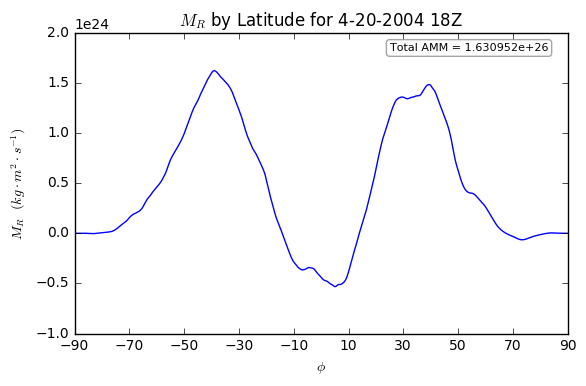

In [12]:
#plt.plot(lats[:,0],aam) # plot latitude (x-axis) by global relative aam (y-axis)
plt.plot(lats[:,0],aam)
plt.title(r"$M_R$" ' by Latitude for ' +str(month)+'-'+str(day)+'-'+str(year)+' '+str('%02d'%hour)+'Z') #Make a title
plt.xlabel(r"$\phi$") #Label x-axis
plt.ylabel(r"$M_R$"+'  '+r"$(kg \cdot m^2 \cdot s^{-1})$") #Label y-axis
plt.xlim(-90,90) #Set limits on the x-axis
plt.xticks(np.arange(-90,110,20)) #Set x-axis ticks every 20 deg
plt.tight_layout() #Make a nice layout
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.7)
plt.annotate('Total AMM = '+'{:e}'.format(np.sum(aam)),xycoords='figure fraction', xytext=(.8,0.95),xy=(.8,0.95), textcoords='axes fraction',ha="center", va="center", size=8,bbox=bbox_props) #Annotate total AAM on the plot
plt.show() #Display the plot